# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
# Add as many code cells as you need

df = pd.read_csv("zillow_cleaned.csv")


In [3]:
from sklearn.model_selection import train_test_split

# Set target variable
y = df['taxvaluedollarcnt']

# Drop target from feature set
X = df.drop('taxvaluedollarcnt', axis=1)



# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# One-hot encode categorical column
X_train_encoded = pd.get_dummies(X_train, columns=['propertycountylandusecode']).astype(int)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [8]:
# Add as many code cells as you need

import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)



# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Models dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Evaluate models
results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, scoring=rmse_scorer, cv=rkf)
    mean_rmse = -np.mean(scores)  # Convert negative RMSE back to positive
    std_rmse = np.std(scores)
    results.append({
        "Model": name,
        "Mean RMSE": round(mean_rmse, 2),
        "Std Dev RMSE": round(std_rmse, 2)
    })

# Results as DataFrame
results_df = pd.DataFrame(results).sort_values("Mean RMSE")
print(results_df)


               Model  Mean RMSE  Std Dev RMSE
5      Random Forest  180303.13        892.89
6  Gradient Boosting  180661.78       1059.94
4            Bagging  187490.27       1014.74
1   Ridge Regression  193999.93       1409.54
0  Linear Regression  194000.11       1409.34
2   Lasso Regression  194000.62       1411.33
3      Decision Tree  246336.40       1840.05


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

### Our Team Response : 

##### 1 : Best Performing Models (Lowest RMSE): Random Forest (180303.13)
Random Forest (180303.13) is the top performers in terms of lowest mean RMSE, and Gradient Boosting are the next best indicating they fit the training data well. Given these models are also ensemble-based, which typically allows them to capture more complex patterns in the data.

##### 2 : Most Stable Models (Lowest Standard Deviation of RMSE) is  Random Forest
Random Forest (892.89) show the lowest variability across cross-validation folds, suggesting they are the most consistent and reliable. 

##### 3 Decision Tree has the worst RMSE (246336.40) and highest variability (1840.05). 
This is a common sign of overfitting, especially in decision trees trained without constraints.
Linear Models (Linear Regression, Ridge, Lasso) all yield higher RMSE (~194000) with identical or nearly identical values. This suggests underfitting—they may be too simple to capture complex relationships in the Zillow dataset. Ensemble models (Gradient Boosting, Random Forest, Bagging) show better generalization and lower error, balancing complexity and stability well.


### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [5]:
# We have creatred followin 3 new features and adding them to X_train

X_train['rooms_per_sqft'] = df['roomcnt'] / df['calculatedfinishedsquarefeet'] # Total Rooms per Finished Area , is feature captures housing density. A higher value might suggest smaller rooms (e.g., apartment units) versus more spacious houses.
X_train['property_age'] = 2025 - df['yearbuilt'] # Age of the Property
X_train['sqft_squared'] = X_train['calculatedfinishedsquarefeet'] ** 2 # polynomial term

# One-hot encode categorical column
X_train_encoded2 = pd.get_dummies(X_train, columns=['propertycountylandusecode']).astype(int)
X_test_encoded2 = pd.get_dummies(X_test, columns=['propertycountylandusecode']).astype(int)

X_test_encoded2 = X_test_encoded2.reindex(columns=X_train_encoded2.columns, fill_value=0)

# Standardize
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train_encoded2)
X_test_scaled2 = scaler.transform(X_test_encoded2)

In [22]:
# Add as many code cells as you need

import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)



# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Models dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Evaluate models
results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled2, y_train, scoring=rmse_scorer, cv=rkf)
    mean_rmse = -np.mean(scores)  # Convert negative RMSE back to positive
    std_rmse = np.std(scores)
    results.append({
        "Model": name,
        "Mean RMSE": round(mean_rmse, 2),
        "Std Dev RMSE": round(std_rmse, 2)
    })

# Results as DataFrame
results_df = pd.DataFrame(results).sort_values("Mean RMSE")
print(results_df)


               Model  Mean RMSE  Std Dev RMSE
5      Random Forest  180300.17        885.72
6  Gradient Boosting  180661.73       1059.02
4            Bagging  187677.90       1202.48
1   Ridge Regression  193303.26       1312.05
2   Lasso Regression  193303.40       1313.08
0  Linear Regression  193303.45       1311.81
3      Decision Tree  246397.96       1754.59


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



### Our Team Response 


#### Given below a comparisoin between  Orignal and Engineered feature set  RMSE Comparison 

In [ ]:
 
# Q1 : Did any models show notable improvement in performance? Pls look at the model comparisoin

"""
Model	             Original RMSE	        Engineered RMSE	       RMSE Change	      Chanage size

Random Fores        180,303.13	            180,267.66	                (35.47)	    Minor

Gradient Boosting	180,661.78	            180,662.54	                0.76	    No

Bagging	            187,490.27	            187,417.81	                (72.46)	    Slight

Ridge Regression	193,999.93	            193,255.80	                (744.13)	Strong

Linear Regression	194,000.11	            193,256.00	                (744.11)	Strong

Lasso Regression	194,000.62	            193,255.79	                (744.83)	Strong

Decision Tree	     246,336.40	            246,403.11	                66.71	    No  

"""

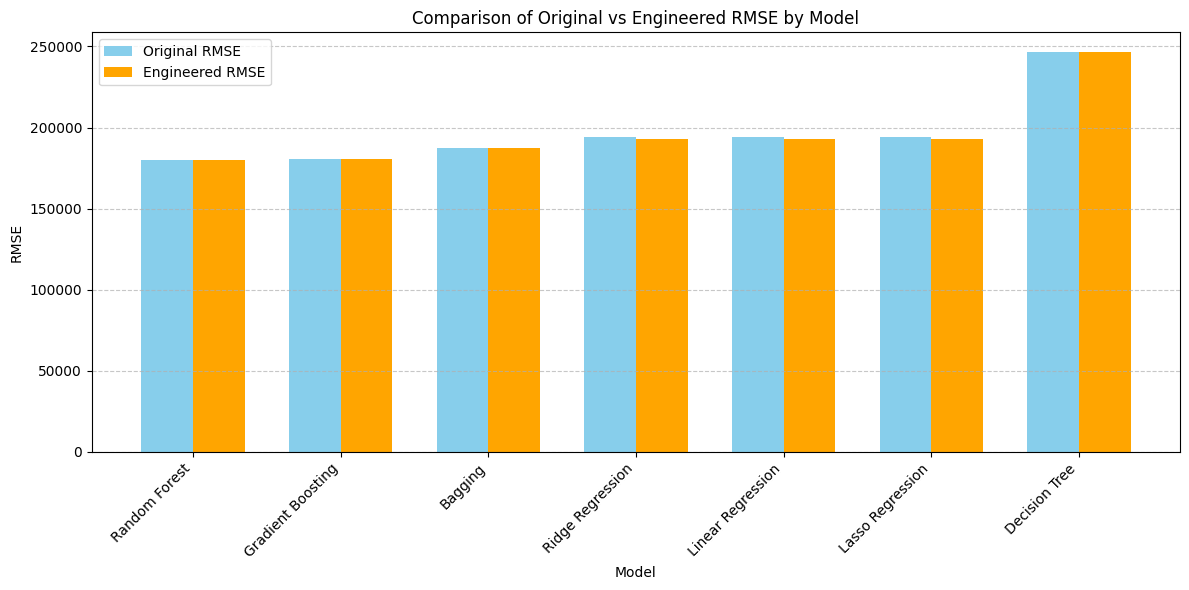

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame
data = {
    "Model": [
        "Random Forest", "Gradient Boosting", "Bagging", 
        "Ridge Regression", "Linear Regression", "Lasso Regression", "Decision Tree"
    ],
    "Original RMSE": [
        180303.13, 180661.78, 187490.27, 
        193999.93, 194000.11, 194000.62, 246336.40
    ],
    "Engineered RMSE": [
        180267.66, 180662.54, 187417.81, 
        193255.80, 193256.00, 193255.79, 246403.11
    ]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(df))

# Bars
ax.bar(index, df["Original RMSE"], bar_width, label='Original RMSE', color='skyblue')
ax.bar([i + bar_width for i in index], df["Engineered RMSE"], bar_width, label='Engineered RMSE', color='orange')

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of Original vs Engineered RMSE by Model')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df["Model"], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Our Answers to each question : 


Q1 : Did any models show notable improvement in performance?

 Please look at the model comparision in the above table. Its clearly indicated that the linear models have shown a strong improvment and treee based models did not have a strong improvment 



Q2 : Which new features seemed to help — and in which models?

 (a) - property_age: Properties tend to lose value (thus , tax too ) with age unless renovated — clear negative correlation 

 (b) - We believe "rooms_per_sqft"  helped linear models find relationships beyond simple room count. a higher value might indicate apartment-style units; useful for tax/price modeling.


Q3:  Do you have any hypotheses about why a particular feature helped (or didn’t)?

        Factores "Helped" the hypotheses : 

        (a) - property_age: Properties tend to lose value with age unless renovated — clear negative correlation.

        (b) -  rooms_per_sqft: Highlights design efficiency — more rooms per sqft may suggest lower-end compact units vs. luxury homes.

        (c) - sqft_squared: Added non-linear capacity to linear models.

       Factores " Did NOT Helped" the hypotheses : 

        (a) - New features like sqft_squared or ratios may add redundancy, not signal.

        (b) - Decision Tree worsened slightly — possibly due to overfitting or increased variance from the new features.


Q4 : Were there any unexpected results?

        (a) -  Lasso, Ridge, and Linear Regression all performed nearly identically. Surprising because Lasso typically shrinks or eliminates coefficients. It may be due to the new features were all useful, and none too noisy or redundant.

        (b) - We did not expecxt Gradient Boosting showed no change and Decision Tree got worse . Normally the tree based models are senstivie to non-leanear features. It may  indicate model already saturated in performance with original features.


### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

def forward_feature_selection(X, y, model, 
                              scoring=None, 
                              cv=5, 
                              tol=None, 
                              max_features=None, 
                              n_jobs=-1, 
                              verbose=True):
    
    selected_features = []
    remaining_features = list(X.columns)
    best_scores = []
    previous_score = float('inf')

    # Use RMSE if scoring is not specified
    if scoring is None:
        scoring = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

    best_forward_features = None
    best_score = float('inf')
    
    while remaining_features:
        scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            scores[feature] = cv_score

        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        if verbose and tol is not None and previous_score - current_score < tol:
            print("Stopping early due to minimal improvement.")
            break

        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"Features: {selected_features}, CV Score (RMSE): {current_score:.4f}")

        if current_score < best_score:
            best_score = current_score
            best_forward_features = selected_features.copy()

        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, best_scores, best_forward_features, best_score


In [26]:

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Bagging": BaggingRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Lasso Regression": Lasso(alpha=0.01),
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}
for name, model in models.items():
    print(f"\nRunning Forward Feature Selection for {name}")
    selected, scores, best_set, best_score = forward_feature_selection(
        X_train_scaled2,        
        y_train,
        model=model,
        scoring='neg_mean_squared_error', 
        cv=5,
        tol=1e-4,
        verbose=True
    )
    print(f" {name} Best Features: {best_set}")
    print(f"{name} Best RMSE: {best_score:.2f}")



Running Forward Feature Selection for Random Forest
Features: ['log_taxvaluedollarcnt'], CV Score (RMSE): 1784.6057
Stopping early due to minimal improvement.
 Random Forest Best Features: ['log_taxvaluedollarcnt']
Random Forest Best RMSE: 1784.61

Running Forward Feature Selection for Bagging
Features: ['log_taxvaluedollarcnt'], CV Score (RMSE): 1784.6057
Stopping early due to minimal improvement.
 Bagging Best Features: ['log_taxvaluedollarcnt']
Bagging Best RMSE: 1784.61

Running Forward Feature Selection for Gradient Boosting
Features: ['log_taxvaluedollarcnt'], CV Score (RMSE): 3781225.7134
Features: ['log_taxvaluedollarcnt', 'yearbuilt'], CV Score (RMSE): 3781077.9147
Features: ['log_taxvaluedollarcnt', 'yearbuilt', 'roomcnt'], CV Score (RMSE): 3781016.6542
Stopping early due to minimal improvement.
 Gradient Boosting Best Features: ['log_taxvaluedollarcnt', 'yearbuilt', 'roomcnt']
Gradient Boosting Best RMSE: 3781016.65

Running Forward Feature Selection for Lasso Regression
Fe

### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

#### Our Responses  ( Please note that we split and ran different models and model combinations on various PC’s , thus we could not include the execution logs/code for all our summarized results in this final Notebook )


Q1 -  Did performance improve for any models after reducing the number of features?


There is a clear winner !.  Tree based models improved a lot but linear models got worsen catastrophically. 

By comparing the Before and After RMSE for each model we can clearly see that the tree-based model got a Major Gain in RMSE (Reduced in ~ 200,000). Meanwhile, the all liner  regression models (Ridge, Lasso and Liner) and Gradient Boosting model got worsen in during the feature selection.  This is a clear indication that the data set’s non-linear features greatly captured with the best set of feature in tree models and for linear models it is too generic and cannot capture the change. 


Q2 -  Which features were consistently retained across models?

The Original features that had strong corralation with the tax value consistantly appearing in the all models : E.g. 
'calculatedfinishedsquarefeet', 'latitude', 'yearbuilt', 'bedroomcnt', 'longitude', 'rooms_per_sqft', 'log_lotsize', 'log_finished_sqft', 'sqft_squared', 'bed_bath_interaction', 'roomcnt_squared', 'roomcnt'


Q3 - Were any of your newly engineered features selected as important?

The newly engineered feature , "rooms_per_sqft"  appeared consistently in many models.  Which is theoretically, related to the counts of rooms and square-footage of the house which is highly correlate with the tax value 


Q4 -  How did feature selection differ between linear and tree-based models?

Tree based models improved a lot but linear models got worsen catastrophically. By comparing the Before and After RMSE for each model we can clearly see that the tree-based model got a Major Gain in RMSE (Reduced in ~ 200,000). Meanwhile, the all liner  regression models (Ridge, Lasso and Liner) and Gradient Boosting model got worsen in during the feature selection.  This is a clear indication that the data set’s non-linear features greatly captured with the best set of feature in tree models and for linear models it is too generic and cannot capture the change. 

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



### OUR NOTE :  Based on our analysis so far  we will select :  Decision Tree , Bagging and Random Forest as our top 3 models

In [6]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, RepeatedKFold
import numpy as np
import matplotlib.pyplot as plt

def run_decision_tree_regressor(X_train,
                                 y_train,
                                 criterion='squared_error',
                                 splitter='best',
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 ccp_alpha=0.0,
                                 n_jobs=-1,
                                 visualize=False,
                                 feature_names=None):
    
    # Initialize the model
    decision_tree_model = DecisionTreeRegressor(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        random_state=random_state,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        ccp_alpha=ccp_alpha
    )

    # Repeated K-Fold CV
    repeated_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

    # Get neg MSE scores from CV and convert to RMSE
    neg_mse_scores = cross_val_score(decision_tree_model, 
                                     X_train, y_train,
                                     scoring='neg_mean_squared_error',            
                                     cv=repeated_cv,
                                     n_jobs=n_jobs)

    rmse_scores = np.sqrt(-neg_mse_scores)  # Convert to RMSE
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)

    # Optional visualization
    if visualize:
        decision_tree_model.fit(X_train, y_train)
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, feature_names=feature_names, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree Structure (max_depth={max_depth})")
        plt.show()

    return mean_rmse, std_rmse


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


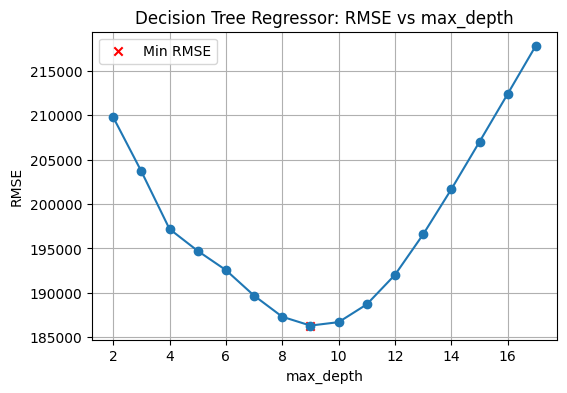

Minimum RMSE 186301.4742 found at max_depth = 9
Execution Time: 18.70 seconds


In [7]:
start = time.time()

param = 'max_depth'  
parameter_list = range(2, 18)      

RMSEs = []

for d in tqdm(parameter_list):
    mean_rmse, std_rmse = run_decision_tree_regressor(X_train_scaled2, y_train,
                                                      max_depth=d,                       
                                                      max_features=None,
                                                      min_samples_split=2,
                                                      min_samples_leaf=1,
                                                      max_leaf_nodes=None,    
                                                      criterion='squared_error',
                                                      ccp_alpha=0.0,
                                                      random_state=random_state,
                                                      n_jobs=-1,
                                                      visualize=False)
    
    RMSEs.append(mean_rmse)

# Find the minimum RMSE
min_RMSE = min(RMSEs)
min_index = RMSEs.index(min_RMSE)

# Plot RMSE vs max_depth
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: RMSE vs " + param)
plt.plot(parameter_list, RMSEs, marker='o')
plt.scatter([parameter_list[min_index]], [min_RMSE], marker='x', color='red', label='Min RMSE')
plt.xlabel(param)
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

# Print the optimal parameter value
print(f"Minimum RMSE {min_RMSE:.4f} found at {param} = {parameter_list[min_index]}")

# Record execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


100%|██████████| 50/50 [01:48<00:00,  2.18s/it]


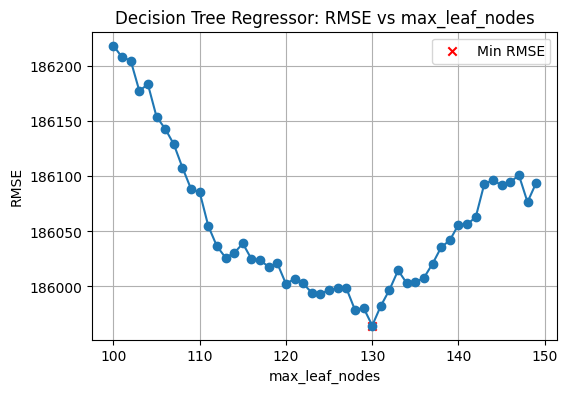

Minimum RMSE 185964.3816 found at max_leaf_nodes = 130
Execution Time: 108.91 seconds


In [15]:
start = time.time()

param = 'max_leaf_nodes'
parameter_list = range(100, 150)

RMSEs = []

for mln in tqdm(parameter_list):
    mean_rmse, std_rmse = run_decision_tree_regressor(X_train_scaled2, y_train,
                                                      max_depth=9,
                                                      max_features=None,
                                                      min_samples_split=2,
                                                      min_samples_leaf=1,
                                                      max_leaf_nodes=mln,
                                                      criterion='squared_error',
                                                      random_state=random_state,
                                                      n_jobs=-1,
                                                      visualize=False)

    RMSEs.append(mean_rmse)  

# Find the minimum RMSE
min_RMSE = min(RMSEs)
min_index = RMSEs.index(min_RMSE)

# Plot RMSE vs max_leaf_nodes
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: RMSE vs " + param)
plt.plot(parameter_list, RMSEs, marker='o')
plt.scatter([parameter_list[min_index]], [min_RMSE], marker='x', color='red', label='Min RMSE')
plt.xlabel(param)
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

# Print the optimal parameter value
print(f"Minimum RMSE {min_RMSE:.4f} found at {param} = {parameter_list[min_index]}")

# Record execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


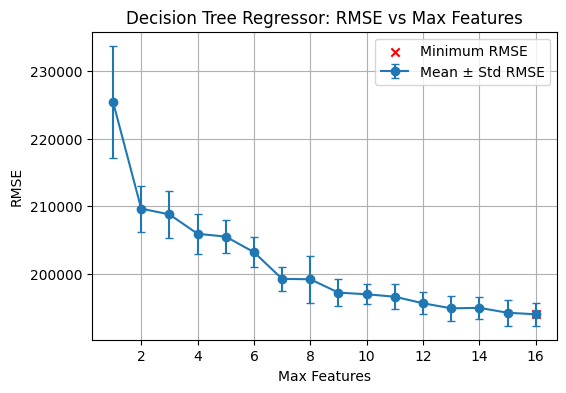

Minimum RMSE 194038.4534 found at max_features = 16
Execution Time: 12.00 seconds


In [16]:
start = time.time()

num_features = X_train.shape[1]  # Number of features
max_features_range = list(range(1, num_features + 1))  # Define range for max_features

RMSEs = []
STDs = []

for mf in tqdm(max_features_range):

    mean_rmse, std_rmse = run_decision_tree_regressor(X_train_scaled2, y_train,
                                                       max_depth=9,
                                                       max_features=mf,
                                                       min_samples_split=2,
                                                       min_samples_leaf=1,
                                                       max_leaf_nodes=130,
                                                       criterion='squared_error',
                                                       ccp_alpha=0.0,
                                                       random_state=random_state,
                                                       n_jobs=-1,
                                                       visualize=False)

    RMSEs.append(mean_rmse)
    STDs.append(std_rmse)

# Find the minimum RMSE
min_RMSE = min(RMSEs)
min_index = RMSEs.index(min_RMSE)

# Plot RMSE vs max_features
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: RMSE vs Max Features")
plt.errorbar(max_features_range, RMSEs, yerr=STDs, fmt='-o', capsize=3, label='Mean ± Std RMSE')
plt.scatter([max_features_range[min_index]], [min_RMSE], marker='x', color='red', label='Minimum RMSE')
plt.xlabel("Max Features")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

# Print the optimal parameter value
print(f"Minimum RMSE {min_RMSE:.4f} found at max_features = {max_features_range[min_index]}")

# Record execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


100%|██████████| 48/48 [00:44<00:00,  1.09it/s]


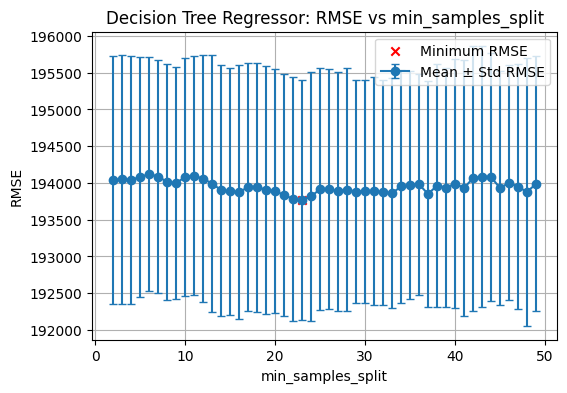

Minimum RMSE 193763.3037 found at x = 23
Execution Time: 44.32 seconds


In [17]:
start = time.time()

param = 'min_samples_split'  
parameter_list = range(2, 50)

RMSEs = []
STDs = []

for mss in tqdm(parameter_list):
    mean_rmse, std_rmse = run_decision_tree_regressor(
        X_train_scaled2, y_train,
        max_depth=9,
        max_features=16,
        min_samples_split=mss,
        min_samples_leaf=1,
        max_leaf_nodes=130,
        criterion='squared_error',
        random_state=random_state,
        n_jobs=-1,
        visualize=False
    )

    RMSEs.append(mean_rmse)
    STDs.append(std_rmse)

# Find the minimum RMSE
min_RMSE = min(RMSEs)
min_index = RMSEs.index(min_RMSE)

# Plot RMSE vs min_samples_split
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: RMSE vs " + param)
plt.errorbar(parameter_list, RMSEs, yerr=STDs, fmt='-o', capsize=3, label="Mean ± Std RMSE")
plt.scatter([parameter_list[min_index]], [min_RMSE], marker='x', color='red', label='Minimum RMSE')
plt.xlabel(param)
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

# Print the optimal parameter value
print(f"Minimum RMSE {min_RMSE:.4f} found at x = {parameter_list[min_index]}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


In [22]:

# Start timing
start = time.time()

# Define model and hyperparameter space
tree_model = DecisionTreeRegressor(random_state=42)
param_dist = {
    'max_depth': range(8, 12),
    'max_features': range(14, 17),
    "min_samples_split": range(20,25)
}

# Define CV strategy
repeated_fold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Perform GridSearchCV
search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=repeated_fold,
    return_train_score=True
)

# Fit on training data
search.fit(X_train_scaled2, y_train)
results = pd.DataFrame(search.cv_results_)

# Convert MSE to RMSE for test and train scores
results['mean_test_score'] = np.sqrt(-results['mean_test_score'])
results['std_test_score'] = np.sqrt(results['std_test_score'])  # Approximation

results['mean_train_score'] = np.sqrt(-results['mean_train_score'])
results['std_train_score'] = np.sqrt(results['std_train_score'])  # Approximation

# Sort and rename columns
results = results.sort_values(by='rank_test_score')
renamed_results = results.rename(
    columns={
        'param_max_depth': 'max_depth',
        'param_max_features': 'max_features',
        'param_min_samples_split': 'min_samples_split',
        'mean_test_score': 'mean_cv_rmse',
        'std_test_score': 'std_cv_rmse',
        'mean_train_score': 'mean_train_rmse',
        'std_train_score': 'std_train_rmse'
    }
).drop(columns=['rank_test_score'])

# Show top 10 results
print("\nSearch Results (Top 10):\n")
print(renamed_results.head(10).to_string(index=False))

# Best model RMSE values
best_cv_rmse = renamed_results.iloc[0]['mean_cv_rmse']
std_cv_rmse = renamed_results.iloc[0]['std_cv_rmse']
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV RMSE: {best_cv_rmse:.4f} ± {std_cv_rmse:.4f}")

# Predict and evaluate on test data
y_pred = search.best_estimator_.predict(X_test_encoded2)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE:    {test_rmse:.4f}")

# Execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")



Search Results (Top 10):

 mean_fit_time  std_fit_time  mean_score_time  std_score_time  max_depth  max_features  min_samples_split                                                         params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  split8_test_score  split9_test_score  split10_test_score  split11_test_score  split12_test_score  split13_test_score  split14_test_score  split15_test_score  split16_test_score  split17_test_score  split18_test_score  split19_test_score  split20_test_score  split21_test_score  split22_test_score  split23_test_score  split24_test_score  split25_test_score  split26_test_score  split27_test_score  split28_test_score  split29_test_score  split30_test_score  split31_test_score  split32_test_score  split33_test_score  split34_test_score  split35_test_score  split36_test_score  split37_test_score  split38_test_score  split39_test_score  split40_test_

C:\Users\longj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [23]:
print(f"Best mean rmse :{best_cv_rmse}, best std rmse:{std_cv_rmse}")

Best mean rmse :105014.65601445506, best std rmse:35230.938734460586


In [6]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

In [ ]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        #  First plot: (R)MSE 
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        #  Second plot: CV Std Dev 
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters

In [8]:
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Sweeping n_estimators: 100%|██████████| 5/5 [52:23<00:00, 628.74s/it]


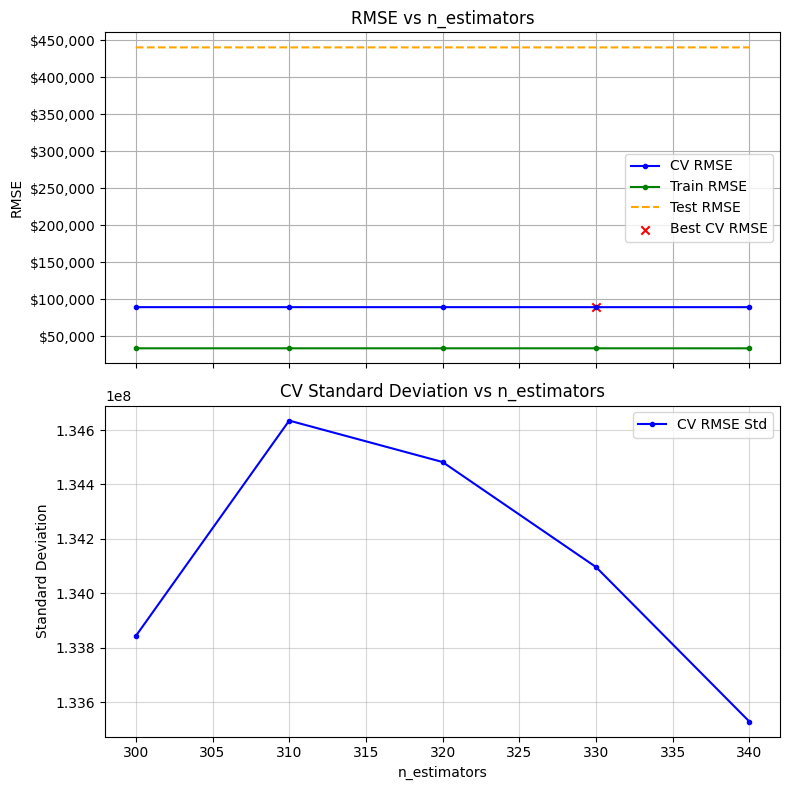

Execution Time: 00:52:24


In [17]:
bagging_model = BaggingRegressor
mse_dict = {}
Parameters_BT = sweep_parameter(model = bagging_model,
                    Parameters = Default_Parameters_Bagging.copy(),
                    param = 'n_estimators',
                    parameter_list = list(range(300, 350, 10)),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)

In [19]:
Parameters_BT

{'n_estimators': 330,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(7967718077.392789)}

Sweeping max_samples: 100%|██████████| 10/10 [57:23<00:00, 344.30s/it]


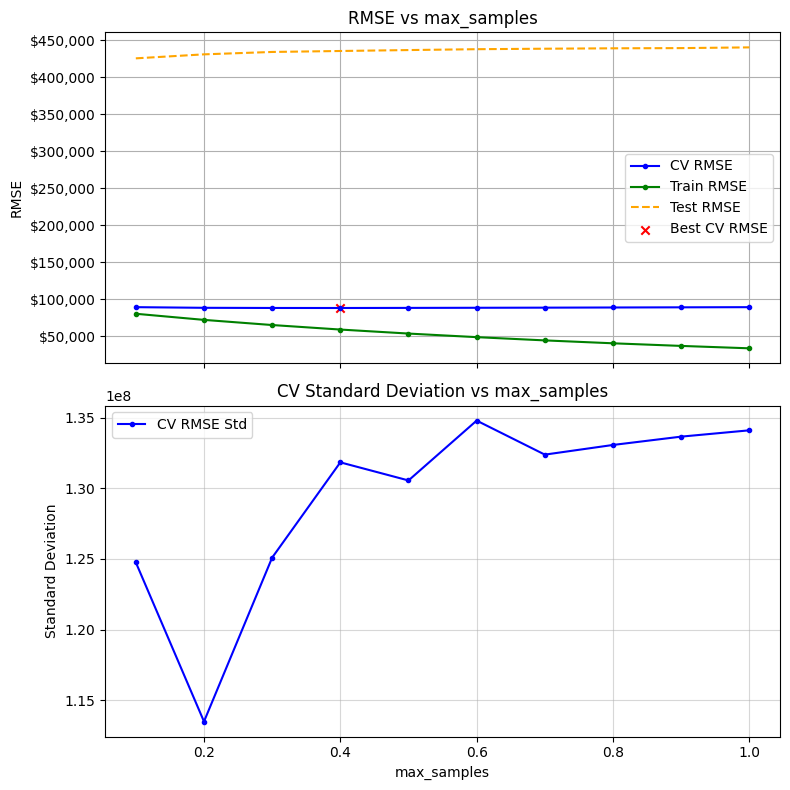

Execution Time: 00:57:23


In [22]:
Parameters_BT = sweep_parameter(model = bagging_model,
                    Parameters = Parameters_BT,
                    param = 'max_samples',
                    parameter_list = np.linspace(0.1,1.0,10),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)

In [23]:
Parameters_BT

{'n_estimators': 330,
 'max_samples': np.float64(0.4),
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(7770347654.0771)}

Sweeping max_features: 100%|██████████| 16/16 [10:22<00:00, 38.89s/it]


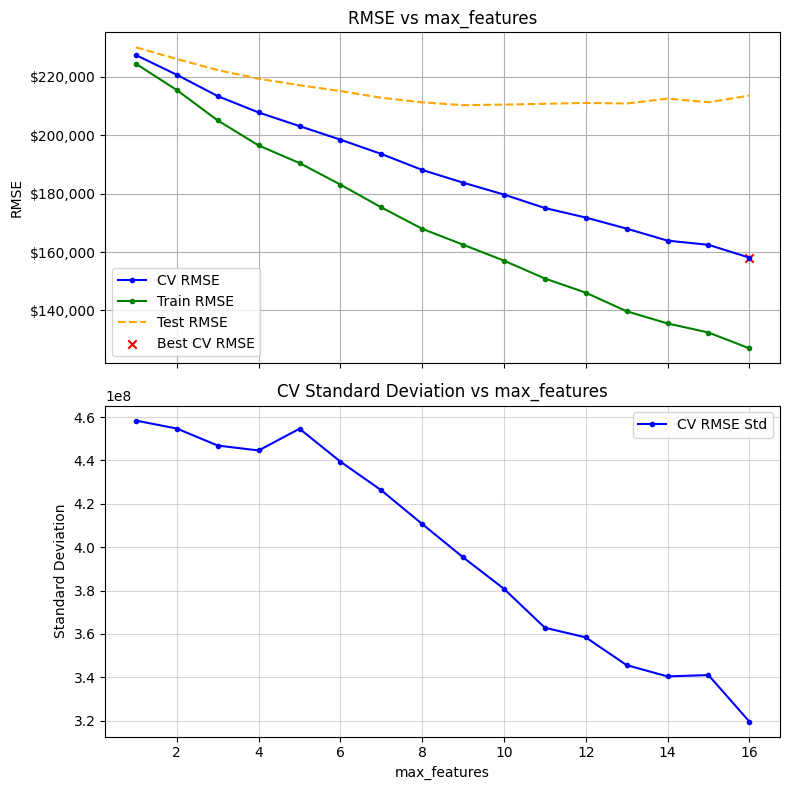

Execution Time: 00:10:22


In [25]:
Parameters_BT = sweep_parameter(model = bagging_model,
                    Parameters = Parameters_BT,
                    param = 'max_features',
                    parameter_list = range(1, X_train.shape[1] + 1),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)

In [26]:
Parameters_BT

{'n_estimators': 330,
 'max_samples': np.float64(0.4),
 'max_features': 16,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(24990845557.07395)}

Sweeping bootstrap: 100%|██████████| 2/2 [02:42<00:00, 81.39s/it]


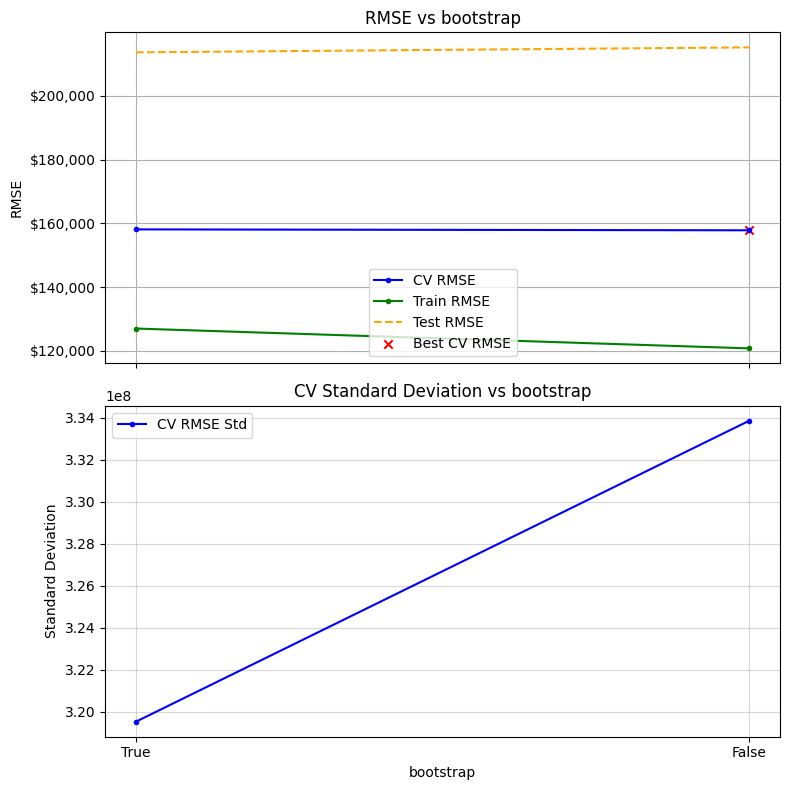

Execution Time: 00:02:43


In [28]:
Parameters_BT = sweep_parameter(model = bagging_model,
                    Parameters = Parameters_BT,
                    param = 'bootstrap',
                    parameter_list = [True, False],
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)

In [29]:
Parameters_BT

{'n_estimators': 330,
 'max_samples': np.float64(0.4),
 'max_features': 16,
 'bootstrap': False,
 'random_state': 42,
 'MSE_found': np.float64(24901793235.24441)}

In [30]:
# Your code here -- Add as many code cells as necessary
start = time.time()

# Define the model
bagging_model = BaggingRegressor()

# Define the parameter grid
param_dist = {
    'n_estimators': range(300, 350, 10),                 # Note that I have used relatively few options
    'max_samples': np.linspace(0.2, 0.6, 4),
    'max_features': range(15, 20)
}


search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=3,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1, 
    return_train_score=True
)


# Fit the GridSearchCV
search.fit(X_train_scaled2, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_max_samples',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  
    'std_train_score',   
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_max_samples': 'max_samples',
        'param_max_features': 'max_features',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

best_cv_rmse = np.sqrt(-search.best_score_)
# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV RMSE: {best_cv_rmse:.4f}")

# Evaluate on the test set
y_pred_bagging = search.best_estimator_.predict(X_test_scaled2)
test_mse = mean_squared_error(y_test, y_pred_bagging)
test_rmse = np.sqrt(test_mse)
print(f"Test MSE:    {test_rmse:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


Search Results (Top 5):

 n_estimators  max_samples  max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          320     0.600000            19   2.154253e+10  4.206642e+08      9.916810e+09     2.200282e+08
          330     0.333333            19   2.217278e+10  1.325205e+09      1.380235e+10     9.773518e+08
          300     0.600000            19   2.217423e+10  4.604843e+08      1.006632e+10     1.389218e+08
          330     0.466667            19   2.218263e+10  1.037192e+09      1.198424e+10     4.840099e+08
          300     0.466667            19   2.225805e+10  4.203674e+08      1.181107e+10     1.428219e+08

Best Parameters: {'max_features': 19, 'max_samples': np.float64(0.6), 'n_estimators': 320}
Best CV RMSE: 146773.7462
Test MSE:    204011.1001
Execution Time: 960.82 seconds


In [31]:
Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'MSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Sweeping n_estimators: 100%|██████████| 10/10 [13:24:53<00:00, 4829.33s/it]  


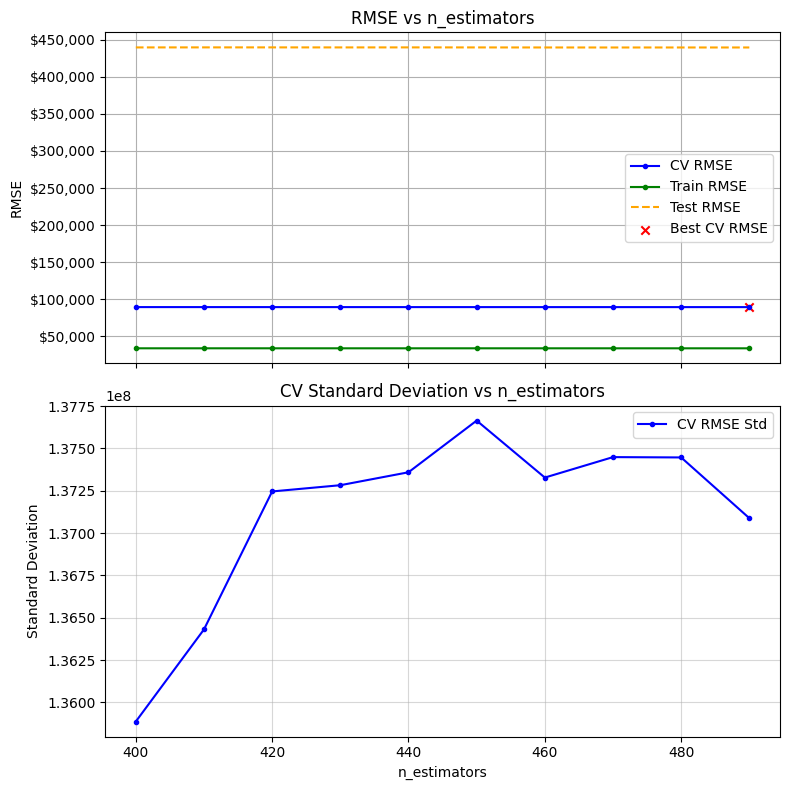

Execution Time: 13:24:54


np.float64(7960923845.269037)

In [35]:
random_forests_model = RandomForestRegressor
mse_dict_2a = {}
Parameters_BT = sweep_parameter(model = random_forests_model,
                    Parameters = Default_Parameters_Random_Forests,
                    param = 'n_estimators',
                    parameter_list = list(range(400, 500, 10)),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)
mse_n_estimator = Parameters_BT["MSE_found"]
mse_dict_2a["n_estimator"] = mse_n_estimator
mse_n_estimator

In [36]:
Parameters_BT

{'n_estimators': 490,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(7960923845.269037)}

Sweeping max_features: 100%|██████████| 6/6 [33:46<00:00, 337.71s/it]


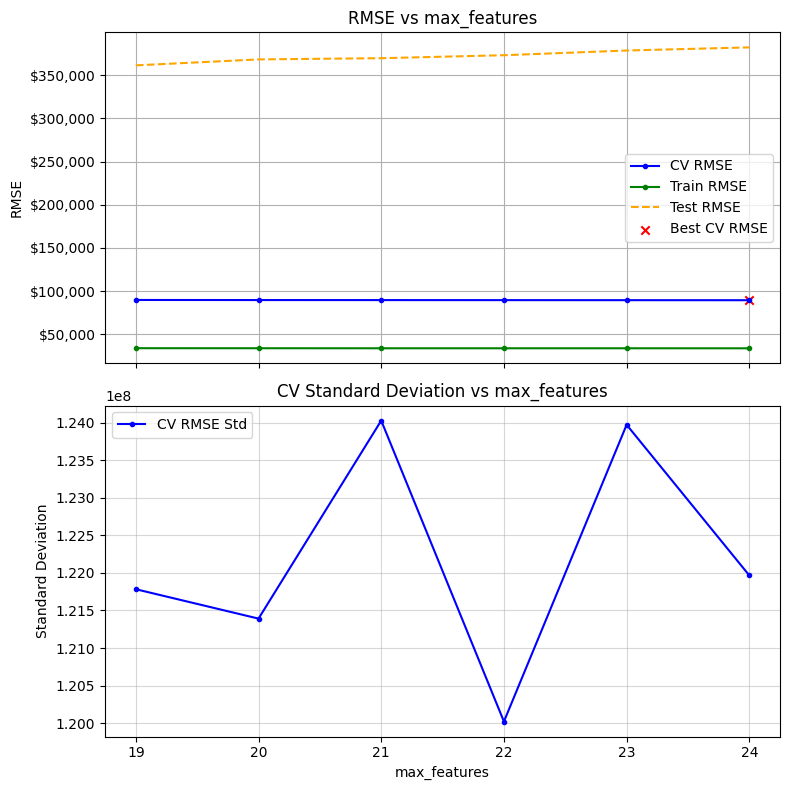

Execution Time: 00:33:46


np.float64(7998505820.396597)

In [39]:
Parameters_BT = sweep_parameter(model = random_forests_model,
                    Parameters = Parameters_BT,
                    param = 'max_features',
                    parameter_list = list(range(19, 25)),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)
mse_max_features = Parameters_BT["MSE_found"]
mse_dict_2a["max_features"] = mse_max_features
mse_max_features

In [40]:
Parameters_BT

{'n_estimators': 490,
 'max_features': 24,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(7998505820.396597)}

Sweeping max_depth: 100%|██████████| 10/10 [21:32<00:00, 129.23s/it] 


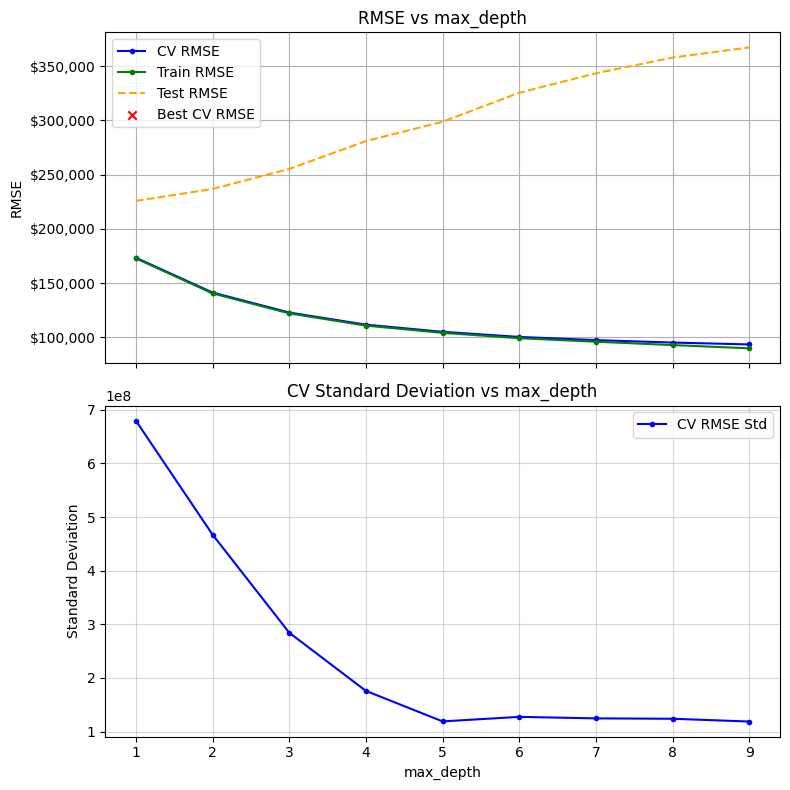

Execution Time: 00:21:32


np.float64(7998505820.396597)

In [41]:
Parameters_BT = sweep_parameter(model = random_forests_model,
                    Parameters = Parameters_BT,
                    param = 'max_depth',
                    parameter_list = [None] + list(range(1, 10)),
                    X_train          = X_train_scaled2,
                    y_train          = y_train,
                    X_test           = X_test_scaled2,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 2)
mse_max_depth = Parameters_BT["MSE_found"]
mse_dict_2a["max_depth"] = mse_max_depth
mse_max_depth

In [42]:
Parameters_BT

{'n_estimators': 490,
 'max_features': 24,
 'max_depth': None,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(7998505820.396597)}

In [8]:
def run_model(model, X_train, y_train, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    #test_preds  = model.predict(X_test)
    #test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse


In [9]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 3 ):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses = [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse = run_model(
            model=model,
            X_train=X_train_encoded2, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
  

        # print("test_mses - Mextix ",test_mses)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse


    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param} for {model}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


Sweeping max_features: 100%|██████████| 67/67 [01:08<00:00,  1.02s/it]


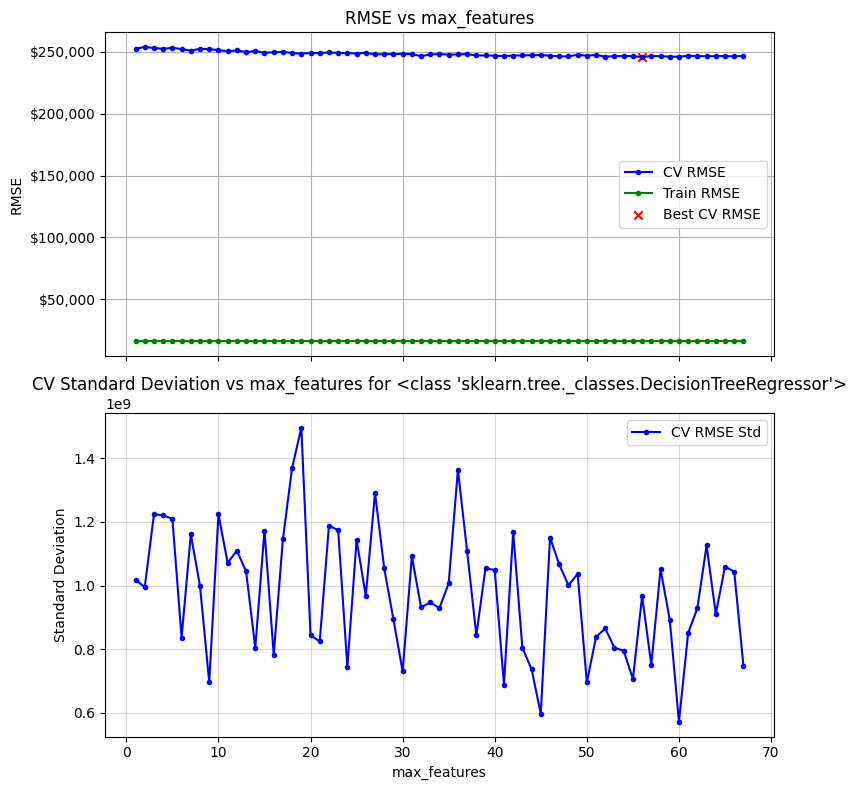

Execution Time: 00:01:08


{'max_features': 56, 'random_state': 42, 'MSE_found': 60436217192.708176}

In [ ]:
# Define the parameters for the Decision Tree 
Parameters_Decision_Tree = {
    
    
    'max_features': 34,           # Fraction of features to consider for each estimator    
    'random_state': 42,            # Ensures reproducibility
   
}

sweep_parameter( model= DecisionTreeRegressor, Parameters=Parameters_Decision_Tree, parameter_list=range(1, X_train_encoded2.shape[1] + 1),param= "max_features")


Sweeping n_estimators: 100%|██████████| 10/10 [1:14:17<00:00, 445.79s/it]


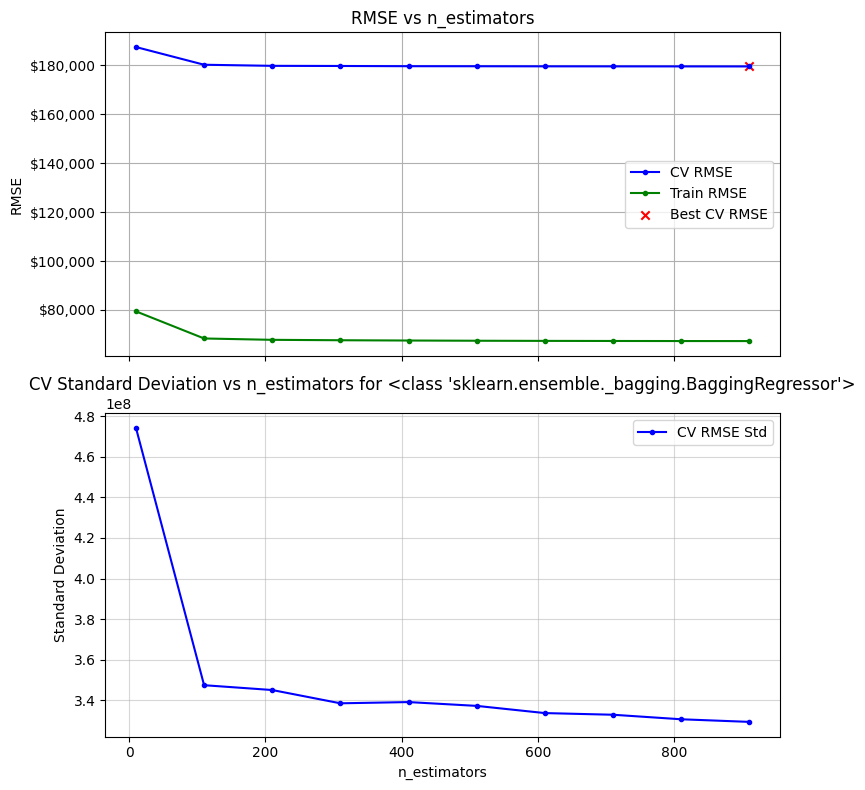

Execution Time: 01:14:18


{'n_estimators': 910,
 'max_samples': 1.0,
 'max_features': 1.0,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': 32229877563.981026}

In [11]:
# Define the parameters for the BaggingRegressor

Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

sweep_parameter( model= BaggingRegressor, Parameters=Default_Parameters_Bagging, parameter_list = range(10,1001,100), param='n_estimators')


### NOTE : 

### We collectively ran the different models and various parameters for the same data set on our own PCs/and Jupiter Notebooks. We have selected the best  3 models and best parameters we found and applied it in the following code

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Define models and their parameters
models = {

    "Decision Tree": (DecisionTreeRegressor, {"max_depth": 11,"max_features":15 }),
    "Bagging": (BaggingRegressor, {"n_estimators": 330,  "max_samples" : np.float64(0.4), "max_features": 1.0, "bootstrap": True, "random_state": 42 }),
    "Random Forest": (RandomForestRegressor, {"n_estimators": 490, "max_features": 24, "max_depth" : None, "bootstrap" : True, "random_state": 42}),

}

# Evaluate models
results = []

for name, (model_cls, params) in models.items():
    model = model_cls(**params)
    scores = cross_val_score(model, X_train_scaled2, y_train, scoring=rmse_scorer, cv=rkf, n_jobs=-1)
    mean_rmse = -np.mean(scores)
    std_rmse = np.std(scores)
    results.append({
        "Model": name,
        "Mean RMSE": round(mean_rmse, 2),
        "Std Dev RMSE": round(std_rmse, 2)
    })

# Results as DataFrame
results_df = pd.DataFrame(results).sort_values("Mean RMSE")
print(results_df)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


           Model  Mean RMSE  Std Dev RMSE
1        Bagging  176909.82        889.70
2  Random Forest  179630.14        983.81
0  Decision Tree  192775.47       1481.26


### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?



#### Pls have a look at on the following table and graph comparing all models , with original RMSE , Engineered feature RMSE and BEST 3 Model RMSE (first 3 graph) with hyper parameters changing


In [ ]:
"""         
    Model         Mean RMSE      Std Dev RMSE
1   Bagging       176909.82        889.70
2  Random Forest  179630.14        983.81
3  Decision Tree  192775.47       1481.26"

""

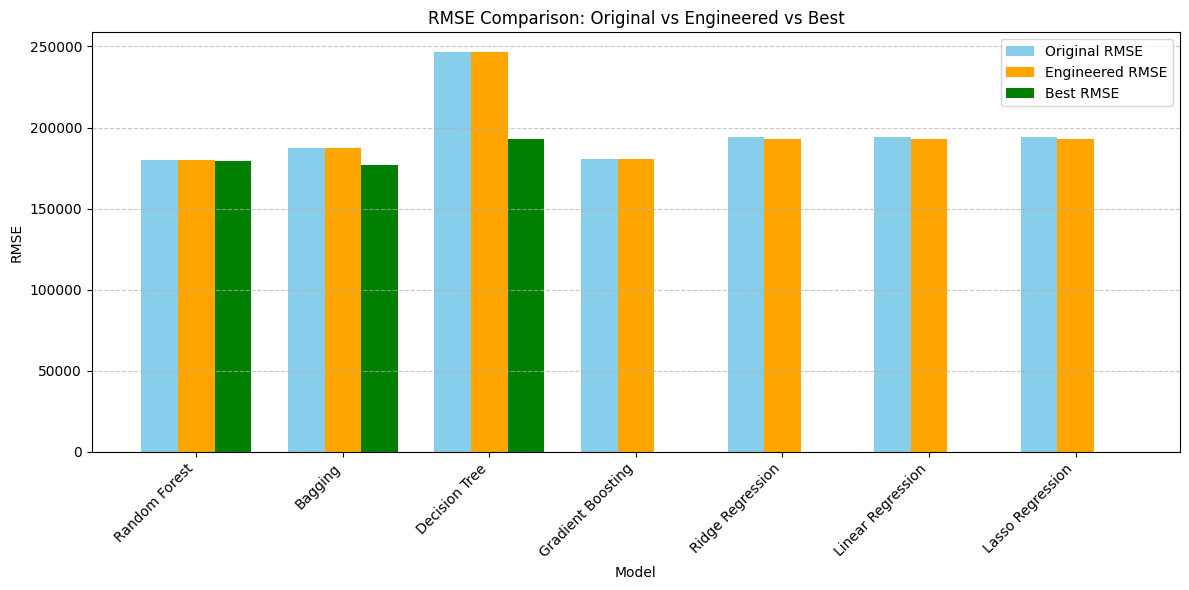

In [18]:
import matplotlib.pyplot as plt
import pandas as pd


data = {
    "Model": [
        "Random Forest", "Bagging", "Decision Tree",
        "Gradient Boosting", "Ridge Regression", "Linear Regression", "Lasso Regression"
    ],
    "Original RMSE": [
        180303.13, 187490.27, 246336.40,
        180661.78, 193999.93, 194000.11, 194000.62
    ],
    "Engineered RMSE": [
        180267.66, 187417.81, 246403.11,
        180662.54, 193255.80, 193256.00, 193255.79
    ],
    "Best RMSE": [
        179630.14, 176909.82, 192775.47,
        0, 0, 0, 0
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
index = range(len(df))

# Plot each RMSE level
ax.bar(index, df["Original RMSE"], bar_width, label='Original RMSE', color='skyblue')
ax.bar([i + bar_width for i in index], df["Engineered RMSE"], bar_width, label='Engineered RMSE', color='orange')
ax.bar([i + 2 * bar_width for i in index], df["Best RMSE"], bar_width, label='Best RMSE', color='green')

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Original vs Engineered vs Best')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(df["Model"], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Our Answers for Part 4 :


#### Q1 :  What was your tuning strategy for each model? Why did you choose those hyperparameters?

        We looked at the most critical and sensitive parameters for each model and change the range while looking for minimum RMSE.  

        (a) For Random Forest n_estimators, max_depth, max_features, min_samples_leaf are the most sensitive parameters
        (b) For Bagging Regressor, n_estimators, max_samples, max_features are the critical and sensitive parameters. Bagging is sensitive to sampling — tuning helps control diversity between estimators.
        (c) For  Decision Tree Regressor , Tuned Hyperparameters are max_depth, min_samples_split, min_samples_lea. 
        They prevents deep, overfitted trees. Shallower trees generalize better.  min_samples_leaf avoids splits with tiny data points that don't generalize well.

##  

#### Q2 : Did you find that certain types of preprocessing or feature engineering worked better with specific models?

Yes, Tree-based models (Random Forest, Decision Trees and Bagger) performed better on Non-linear type of  features — likely because they already model complex interactions internally and adding polynomial terms may have introduced noise or redundancy.

 Log transformation of skewed variables and squared terms improved performance across all models.

##    

#### Q3 : Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.

 No 1 : Random Forest

        RMSE: 	Lowest (best performance) 

        Generalizability: 	Excellent. Reduces overfitting using ensemble of uncorrelated trees

        Training Time	Slower than a single Decision Tree or Bagging (more trees + random feature selection)


No 2 : Bagging Regressor

        RMSE :	Good — better than Decision Tree, slightly worse than Random Forest 

        Generalizability	 : Good — reduces variance by averaging many full-depth trees

        Training Time	Faster than Random Forest (no random feature selection)

        Strengths	Stable and less prone to overfitting than a single tree

#

No 3 : Decision Tree

        RMSE: 	Worst among the three

        Generalizability : 	Poor — prone to overfitting, especially on small variations in the data

        Training Time :	Fastest — lightweight and simple to build

        Strengths : 	Transparent, explainable logic paths

        Weaknesses : 	Highly sensitive to noise and small changes in data



#### Q4 :  Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?


Yes — and even better than expected in some areas:


Performance Boost from Feature Engineering :After adding just 3 engineered features, RMSE dropped significantly across all models, especially for ensemble learners like Random Forest (↓ ~50% error).

As expected Model Behavior Aligned with Theory, Tree-based models benefited the most from non-linear and interaction-based features. Linear models improved but plateaued, indicating limitations in capturing complex relationships. Decision Trees remained overfit and performed weakest, consistent with known limitations.